# Summaries of timing tests

We compare several optimizers, in both [R](http://www.R-project.org) and [Julia](http://julialang.org), fitting a selection of linear mixed models.  In __R__ the optimizers are called by `lmer` from the [lme4 package](https://github.com/lme4/lme4) (version 1.1-8). In __Julia__ the `lmm` function from the [MixedModels package](https://github.com/dmbates/MixedModels.jl) calls the optimizers.

There are differences in the model formulations in `lme4` and in `MixedModels`.  The numerical representation of the model in `lme4` and the method of evaluating the objective, described in [this paper](http://arxiv.org/abs/1406.5823), is the same for all models.  In `MixedModels` there are specialized representations for some model forms, such as models with a single grouping factor for the random effects.  Some of the specialized representations allow for evaluation of the gradient of the objects, which can enhance convergence (but, interestingly, sometimes can impede convergence).

## Methodology

To provide consistency we have copied all the data sets used in the timings to the `Timings` package itself.  We have done all timings on the same computer.  This computer has a relatively recent Intel processor and we used the [Intel Math Kernel Library (MKL)](https://software.intel.com/en-us/intel-mkl) with Julia.  We attempted to use [Revolution R Open (RRO)](www.revolutionanalytics.com/revolution-r-open) as the R implementation as it can be configured with MKL.  However, we ran into version problems with this so we used the standard Ubuntu version of R linked against OpenBLAS, which is also multi-threaded.

Variables were renamed in the pattern:
- __Y__ the response
- __A__, __B__, $\dots$ categorical covariates
- __G__, __H__, __I__, $\dots$ grouping factors for random effects
- __U__, __V__, $\dots$ (skipping __Y__) continuous covariates

The timing results are saved in [JSON (JavaScript Object Notation)](http://json.org) files in the directory accessible as
```r
system.file("JSON",package="Timings")
```
within __R__.  The directory name will end with `./Timings/inst/JSON/` in the package source directory, for example the result of cloning the [github repository](https://github.com/Stat990-033/Timings).  There is one `.json` file for each data set.  Each such file contains results on timings of one or more models.

The `Timings` package for __R__ provides a `retime` function that takes the name of one of these JSON files and, optionally, the name of a file with the updated timings.  Similarly there are some source files for Julia retimings.


In [1]:
include("../julia/retime.jl")
retime("../JSON/Alfalfa.json","/tmp/Alfalfa.json");
retime("../JSON/Alfalfa.json","/tmp/Alfalfa.json");

dsname => "Alfalfa"
form => Formula: Y ~ 1 + B * A + (1 | G)
nopt => 1
mtype => PLSOne
-2log(likelihood) time(s) feval geval optimizer
      -10.8102     0.5050    15     0 bobyqa
      -10.8102     0.0220    36     0 Nelder_Mead
      -10.8102     0.0420    13     0 NLOPT_LN_BOBYQA
      -10.8102     0.0210    22     0 NLOPT_LN_COBYLA
      -10.8102     0.0210    24     0 NLOPT_LN_NELDERMEAD
      -10.8102     0.0220    36     0 NLOPT_LN_SBPLX
      -10.8102     0.1090    14     0 optimx:L-BFGS-B
      -10.8102     0.1290    19     0 optimx:nlminb
      -10.8102     0.2440    NA     0 optimx:spg
      -10.8102     0.1090    NA     0 optimx:bobyqa
      -10.8102     1.2323    15     0 LN_BOBYQA
      -10.8102     0.0025    25     0 LN_COBYLA
      -10.8102     0.0028    26     0 LN_NELDERMEAD
      -10.8102     0.0035    50     0 LN_SBPLX
      -10.8102     0.1413    14    14 LD_MMA
      -10.8102     0.0019    16    16 LD_CCSAQ
      -10.8102     0.0015    10     8 LD_SLSQP
      -10.

The timing was repeated so that compilation time is not included in the results.  This repetition is only needed
once per session.

A careful examination of these results shows that the main differences in the Julia timings (the R timings are merely reported, not evaluated) are that the `LN_BOBYQA` and `LD_MMA` optimizers are much faster in the second run.  This is because much of the code needs to be compiled the first time that a derivative-free optimizer and a derivative-based optimizer are used.

The names of the optimizers used with `lmm` are those from the [NLopt package](https://github.com/JuliaOpt/NLopt.jl) for __Julia__.  Names that begin with `LD_` are gradient-based methods.  Names that begin with `LN_` are derivative-free methods.  There is one other derivative-free method, `LN_PRAXIS`, available in the `NLopt` package but, for some reason, it can hang on very simple problems like this.  Frequently we omit it.

The optimizers used with `lmer` include the `Nelder_Mead` optimizer built into the `lme4` package, the `bobyqa` optimizer from the [minqa package](http://cran.rstudio.com/web/packages/minqa/index.html), the derivative-free optimizers from the [nloptr package](http://cran.rstudio.com/web/packages/nloptr/index.html) and several optimizers from the [optimx pacakge](http://cran.rstudio.com/web/packages/optimx/index.html).

The `optimx:bobyqa` optimizer is just a wrapper around `bobyqa` (bounded optimization by quadratic approximation) from the `minqa` package and should provide results similar to those from the `bobyqa` optimizer.  For some reason the number of function evaluations is not reported for the version in `optimx`.

The optimizers from `nloptr` (i.e. those whose names begin with `NLOPT_LN_`) use the same underlying code as do the similarly named optimizers in the `NLopt` package for __Julia__.  The number of iterations to convergence should be similar for the same underlying code, although not nessarily exactly the same because the evaluation of the objective in __R__ and in __Julia__ may produce slightly different answers.  Also the convergence criteria in the __Julia__ version are more strict than those in the __R__ version

Also shown are the value of the criterion (negative twice the log-likelihood, lower is better) achieved, the elapsed time and the number of function and gradient evaluations.  The `nopt` value is the number of parameters in the optimization problem.  `mtype` is the model type in the __Julia__ code.  There are special methods for solving the penalized least squares (PLS) problem, and for evaluating the objective and its gradient when there is only one grouping factor for the random effects.  The model type is called `PLSOne`.

The `Alfalfa` example is a particularly easy one and all of the optimizerws converge to an objective value close to -10.81023 in less than 0.6 seconds.

### Tabulating results

For the `Alfalfa` data there is not much of a burden in refitting the model with all the __Julia__ optimizers just to get the table shown above.  But other examples can take an hour or more to converge and we don't really need to refit them every time.  The `tabulate.jl` file contains a function `optdir` to create a `DataFrame` from the results of all the model fits.

In [2]:
include("../julia/tabulate.jl")
res = optdir("../JSON");
res[1:30,[1,2,3,6,7,8,9]]

,opt,dsname,n,np,excess,time,reltime
1,LD_CCSAQ,Alfalfa,72,1,0.0,0.0017,1.1342
2,LD_CCSAQ,AvgDailyGain,32,1,0.0,0.0014,0.8207
3,LD_CCSAQ,AvgDailyGain,32,1,0.0,0.0014,0.9283
4,LD_CCSAQ,BIB,24,1,0.0,0.0013,0.7897
5,LD_CCSAQ,Bond,21,1,0.0,0.0009,1.0265
6,LD_CCSAQ,bs10,1104,20,0.0,1.0958,4.4375
7,LD_CCSAQ,bs10,1104,8,39.99475,0.0375,0.555
8,LD_CCSAQ,cake,270,1,0.0,0.0033,1.3714
9,LD_CCSAQ,Cultivation,24,1,0.0,0.0009,0.9925
10,LD_CCSAQ,Demand,77,2,3.21928,0.0055,0.8079


The `time` column is the time in seconds to converge.  The `reltime` column is the time relative to the `LN_BOBYQA` optimizer in the `MixedModels` package for __Julia__.

In [3]:
res[res[:opt] .== "NLOPT_LN_BOBYQA",[1,2,3,6,7,8,9]]

,opt,dsname,n,np,excess,time,reltime
1,NLOPT_LN_BOBYQA,Alfalfa,72,1,0.0,0.042,27.5171
2,NLOPT_LN_BOBYQA,Animal,20,2,0.0,0.023,13.9236
3,NLOPT_LN_BOBYQA,Assay,60,2,1.0e-5,0.032,10.8009
4,NLOPT_LN_BOBYQA,AvgDailyGain,32,1,0.0,0.02,11.7005
5,NLOPT_LN_BOBYQA,AvgDailyGain,32,1,0.0,0.02,13.6969
6,NLOPT_LN_BOBYQA,BIB,24,1,0.0,0.02,12.608
7,NLOPT_LN_BOBYQA,Bond,21,1,0.0,0.02,23.2699
8,NLOPT_LN_BOBYQA,bs10,1104,20,1.0e-5,4.661,18.8753
9,NLOPT_LN_BOBYQA,bs10,1104,8,0.0,1.057,15.6477
10,NLOPT_LN_BOBYQA,cake,270,1,0.0,0.053,22.0827


## Proportion converged

The most important question regarding the optimizers is whether or not they have converged to the global optimum.  We cannot test this directly.  Instead we use a "crowd-sourced" criterion based on the minimum objective achieved by any of the algorithms.  The difference between the objective achieved by a particular algorithm and this minimum is called the `excess`.  In the summaries `excess` is rounded to 5 digits after the decimal so the minimum non-zero `excess` is $10^{-5}$.

In [4]:
res[res[:opt] .== "LN_BOBYQA",[:opt,:dsname,:excess]]

,opt,dsname,excess
1,LN_BOBYQA,Alfalfa,0.0
2,LN_BOBYQA,Animal,0.0
3,LN_BOBYQA,Assay,0.0
4,LN_BOBYQA,AvgDailyGain,0.0
5,LN_BOBYQA,AvgDailyGain,0.0
6,LN_BOBYQA,BIB,0.0
7,LN_BOBYQA,Bond,0.0
8,LN_BOBYQA,bs10,1.0e-5
9,LN_BOBYQA,bs10,0.0
10,LN_BOBYQA,cake,0.0


If we wish to declare "converged" or "not converged" according to the excess objective value we must establish a threshold. An absolute threshold seems reasonable because the objective, negative twice the log-likelihood, is on a scale where differences in this objective are compared to a $\chi^2$ random variable.  Thus an excess of $10^{-9}$ or even $10^{-5}$ is negligible.

For each optimizer we can examine which of the data set/model combinations resulted in an excess greater than a threshold.

In [5]:
by(res,:opt) do df
    DataFrame(attempted=size(df,1),failed=countnz(df[:excess] .> 0.02))
end

,opt,attempted,failed
1,LD_CCSAQ,35,11
2,LD_LBFGS,35,11
3,LD_MMA,36,5
4,LD_SLSQP,35,4
5,LD_TNEWTON,34,8
6,LD_TNEWTON_PRECOND,34,8
7,LD_TNEWTON_PRECOND_RESTART,33,12
8,LD_TNEWTON_RESTART,34,11
9,LD_VAR1,35,10
10,LD_VAR2,35,10


At this threshold the most reliable algorithm in Julia is `LN_BOBYQA`.  In R the most reliable algorithms are `NLOPT_LN_BOBYQA`, `optimx:L-BFGS-B` and `optimx:nlminb`.  It is interesting that nlminb is reliable as I felt that it wasn't converging well when it was the default optimizer in `lmer`.

Interestingly, the derviative-based algorithms in `NLopt` were not as reliable as the derivative-free algorithms. The most likely explanation is that I don't have the gradient coded properly.

The Nelder-Mead simplex algorithm did not perform well, failing on 8 out of 48 cases.  For many of these the value at which convergence was declared was far from the optimum.

In [6]:
noncvg = 
by(res,:opt) do df
    df[df[:excess] .> 0.005,[:dsname,:excess,:time,:reltime,:np,:n]]
end;
dfselect(df::AbstractDataFrame,col::Symbol,val) = df[df[col] .== val, :]
dfselect(noncvg,:opt,"Nelder_Mead")

,opt,dsname,excess,time,reltime,np,n
1,Nelder_Mead,bs10,71.3859,145.368,588.6844,20,1104
2,Nelder_Mead,d3,317.58983,454.519,4.2502,9,130418
3,Nelder_Mead,dialectNL,181.63206,54.541,31.1594,6,225866
4,Nelder_Mead,gb12,78.71194,38.206,189.6049,20,512
5,Nelder_Mead,kb07,398.73182,2825.461,667.0153,72,1790
6,Nelder_Mead,kb07,403.47789,269.436,383.087,16,1790
7,Nelder_Mead,Mississippi,0.04272,0.018,20.3989,1,37
8,Nelder_Mead,mm0,181.63206,76.87,70.0716,6,69588


In [7]:
dfselect(noncvg,:opt,"NLOPT_LN_NELDERMEAD")

,opt,dsname,excess,time,reltime,np,n
1,NLOPT_LN_NELDERMEAD,Assay,0.05942,0.042,14.1762,2,60
2,NLOPT_LN_NELDERMEAD,bs10,0.97096,88.286,357.5243,20,1104
3,NLOPT_LN_NELDERMEAD,d3,100.19076,627.931,5.8718,9,130418
4,NLOPT_LN_NELDERMEAD,gb12,0.83883,52.411,260.1,20,512
5,NLOPT_LN_NELDERMEAD,kb07,88.76861,2839.075,670.2292,72,1790
6,NLOPT_LN_NELDERMEAD,kb07,3.49868,198.845,282.7199,16,1790


The `Nelder_Mead` algorithm, either in the native form in `lmer` or in the `NLopt` implementation performed poorly on those cases with many parameters to optimize.  It was both unreliable and slow, taking over 45 minutes to reach a spurious optimum on the "maximal" model (in the sense of Barr et al., 2012) for the `kb07` data from Kronmueller and Barr (2007).  This is not terribly surprising given that the model is horribly overparameterized, but still it shows that this algorithm is not a good choice in these cases.

We note in passing that all the models involving fitting 20 or more parameters are "maximal" models in the sense of Barr et al., 2012.  Such models can present difficult optimization problems because they are severely overparameterized and inevitably converge on the boundary of the allowable parameter space.  Whether or not it is sensible to compare results on such extreme cases is not clear.

The `SBPLX` (subplex) algorithm, which is an enhancement of `Nelder_Mead`, does better in these cases but is still rather slow.

In [8]:
dfselect(noncvg,:opt,"NLOPT_LN_SBPLX")

,opt,dsname,excess,time,reltime,np,n
1,NLOPT_LN_SBPLX,gb12,0.82219,3.813,18.9228,20,512
2,NLOPT_LN_SBPLX,kb07,4.96546,564.688,133.3076,72,1790


By comparison, the `LN_BOBYQA` algorithm converges quite rapidly on the `kb07` models.

In [9]:
bobyqa = res[convert(Array,res[:opt] .== "LN_BOBYQA") & 
    convert(Array,res[:dsname] .== "kb07"),
    [:dsname,:excess,:objective,:time,:np]]

,dsname,excess,objective,time,np
1,kb07,0.01695,28586.33457,4.236,72
2,kb07,0.0,28670.91332,0.7033,16


## Relative speed

We plot the time to convergence, relative to `LN_BOBYQA` and on a logarithmic scale, for each algorithm.

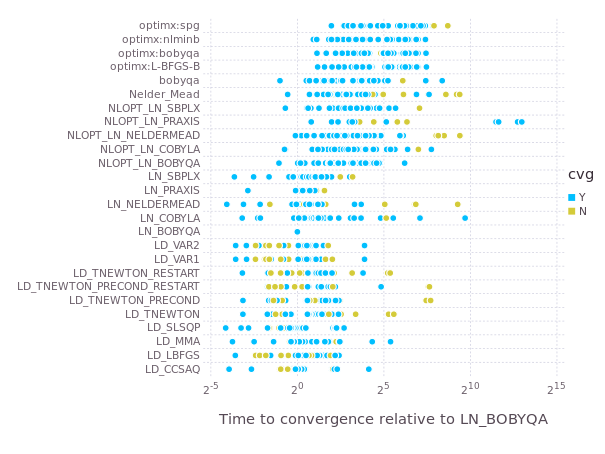

In [10]:
using Gadfly
set_default_plot_size(16cm,12cm)
res[:cvg] = [e > 0.02 ? "N" : "Y" for e in res[:excess]]
plot(res,x="reltime",y="opt",color="cvg",
    Geom.point,Scale.y_discrete,Scale.x_log2,
    Guide.ylabel(nothing),
    Guide.xlabel("Time to convergence relative to LN_BOBYQA"))

Many of the cases where `LN_BOBYQA` is slower than other algorithms are simple problems that converge in less than 0.1 second for most algorithms.  For example, the `bobyqa` optimizer is faster than `LN_BOBYQA` in five cases but all of these are cases where convergence is so fast that it is difficult, and rather meaningless, to measure.

In [11]:
bobyqa = dfselect(res,:opt,"bobyqa");
bobyqa[bobyqa[:reltime] .< 1,[:dsname,:time,:reltime,:np]]

,dsname,time,reltime,np
1,sleepstudy,0.025,0.4983,2


We will declare a data set to be non-simple if at least one of the models fit to the data took more than 0.2 seconds to convergence with `LN_BOBYQA`.

In [12]:
ln_bobyqa = dfselect(res,:opt,"LN_BOBYQA");
nonsimple = ln_bobyqa[ln_bobyqa[:time] .> 0.2,[:dsname,:time,:n,:np,:models]]

,dsname,time,n,np,models
1,bs10,0.2469,1104,20,Y ~ 1+U+V+W + (1+U+V+W|G) + (1+U+V+W|H)
2,d3,106.9401,130418,9,Y ~ U + (U | G) + (U | H) + (U | I)
3,dialectNL,1.7504,225866,6,Y ~ U + V +W +X + Z+A + T +(1 | G) +(0 + V + W+ X | G) +(1 + Z + A | H) +(1 | I)
4,gb12,0.2015,512,20,Y ~ 1+S+T+U+V+W+X+Z + (1+S+U+W|G) + (1+S+T+V|H)
5,InstEval,2.3539,73421,2,Y ~ 1 + I*A + (1|G) + (1|H)
6,InstEval,4.3593,73421,3,Y ~ 1 + A + (1|G) + (1|H) + (1|I)
7,kb07,4.236,1790,72,Y ~ 1+S+T+U+V+W+X+Z + (1+S+T+U+V+W+X+Z|G) + (1+S+T+U+V+W+X+Z|H)
8,kb07,0.7033,1790,16,Y ~ 1+S+T+U+V+W+X+Z + (1|G)+(0+S|G)+(0+T|G)+(0+U|G)+(0+V|G)+(0+W|G)+(0+X|G)+(0+Z|G) + (1|H)+(0+S|H)+(0+T|H)+(0+U|H)+(0+V|H)+(0+W|H)+(0+X|H)+(0+Z|H)
9,mm0,1.097,69588,6,Y~A*U+(1+U|G)+(1+U|H)
10,Poems,5.6918,275996,3,Y ~ 1 + U + V + (1|G) + (1|H) + (1|I)


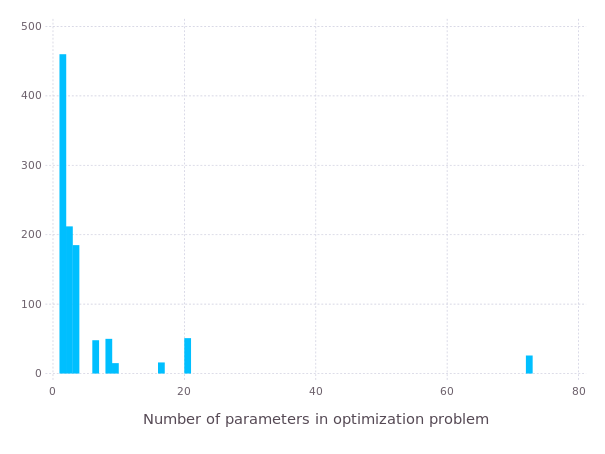

In [13]:
plot(res,x="np",Geom.histogram,
Guide.xlabel("Number of parameters in optimization problem"))